In [1]:
%matplotlib inline
# %matplotlib qt

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from qutip import *
import random
import time
import _thread
from threading import Thread
from mpl_toolkits.mplot3d import Axes3D
import pylab
import matplotlib.animation as animation
from IPython.display import HTML
from scipy import optimize
import sys
from multiprocessing import Pool

In [55]:
##
#Functions for generating, interpreting, and plotting nodes
##
class Node:
    def __init__(self,ind,coord,pairs,err):
        self.id = ind
        self.coord = coord
        self.pairs = pairs
        self.dx = np.random.normal(0,err)
        self.dy = np.random.normal(0,err)

        self.x,self.y = transform(coord,0,0)
        self.xdx = self.x+ self.dx
        self.ydy = self.y+ self.dy
        self.dist = np.sqrt(self.x**2+self.y**2)
        self.comx = 0
        self.comy = 0
theta = np.pi/6


def transform(coord,dx,dy):
    x=round(coord[1]*np.sin(theta)+coord[0]+ coord[2]*(1/3)*(1+np.sin(theta)),3)
    y=round(coord[1]*np.cos(theta)         + coord[2]*(1/3)*(np.cos(theta)),3)
    return x-dx,y-dy

def plotNodes(ax,nodes,t=0):
    coords = []
    values = []
    for ID,node in nodes.items():
        for pair in node.pairs:
            x1,y1 = transform(pair[0],node.comx,node.comy)
            x2,y2 = transform(pair[1],node.comx,node.comy)
            if type(pair[2]) is int:
#                 ax.plot([x1,x2],[y1,y2],color=plt.cm.inferno(1-t),linewidth=11,label=str(node.id),alpha=1-t,zorder=1)
                ax.plot([x1,x2],[y1,y2],color="black",linewidth=4.5,label=str(node.id),alpha=.6-t,zorder=2)


            else:
                if np.imag(pair[2])>0:
                    ax.arrow(x1,y1,x2-x1,y2-y1,length_includes_head=True,color="red",linewidth=3,head_width=.02,alpha=.6-t,zorder=2)
#                     ax.arrow(x1,y1,x2-x1,y2-y1,length_includes_head=True,color=plt.cm.afmhot(1-t),linewidth=10,head_width=.02,zorder=1)
                else:
                    ax.arrow(x2,y2,x1-x2,y1-y2,length_includes_head=True,color="red",linewidth=3,head_width=.02,alpha=.6-t,zorder=2)
#                     ax.arrow(x1,y1,x2-x1,y2-y1,length_includes_head=True,color=plt.cm.afmhot(1-t),linewidth=10,head_width=.02,zorder=1)


#     plt.show()

In [37]:
##
#Functions for generating adjacency matrices from sets of nodes
##

#Generates an adjacency matrix from a list of pairs 
def genAdjMatrix(dim,nodes):
    matrix = np.array([np.zeros(dim,dtype=np.cdouble) for i in range(dim)])
    x=0
    y=0
    for ind, node in nodes.items():
        x+=node.x
        y+=node.y
        if node.pairs:
            n1 = node
            for pair in node.pairs:
                if str(pair[1]) in nodes:
                    n2 = nodes[str(pair[1])]
                    id1=n1.id
                    id2=n2.id
                    if matrix[id1,id2] == 0.+0.j:
                        w = pair[2]
                        if id1!=id2:
                            dist = np.sqrt((n2.x-n1.x)**2+(n2.y-n1.y)**2)
                            alpha = (np.sqrt((n1.xdx-n2.xdx)**2+(n1.ydy-n2.ydy)**2)-dist)/dist**3
                            w+=alpha
                        matrix[id1,id2] = w
                        matrix[id2,id1] = np.conj(w)
#                     print(id1,id2,matrix[id1,id2])
    x/=dim
    y/=dim
    for ind, node in nodes.items():
        node.x-=x
        node.y-=y
        node.comx = x
        node.comy = y
    return matrix, nodes


def symmTess(x,y,wx,wy,wz,a,P):
    if a:
        return [[[x,y,0],[x-1,y,1],wx],[[x,y,0],[x,y-1,1],wy],[[x,y,0],[x,y,1],wz],\
            [[x,y,0],[x+1,y,0],+P],[[x,y,0],[x,y+1,0],-P],[[x,y,0],[x-1,y+1,0],+P]]
    else:
        return [[[x,y,1],[x+1,y,1],-P],[[x,y,1],[x,y+1,1],P],[[x,y,1],[x-1,y+1,1],0-P]]    

def asymmTess(x,y,wx,wy,wz,a,P):
    if a:
        return [[[x,y,1],[x+1,y,0],wx],[[x,y,1],[x,y+1,0],wy],[[x,y,1],[x,y,0],wz],\
            [[x,y,1],[x+1,y,1],-P],[[x,y,1],[x,y+1,1],0+P],[[x,y,1],[x-1,y+1,1],-P]]
    else:
        return [[[x,y,0],[x+1,y,0],0+P],[[x,y,0],[x,y+1,0],0-P],[[x,y,0],[x-1,y+1,0],0+P]]

def asymmAdj(dim,wx,wy,wz,P,err):
    nodes = {str([0,0,1]):Node(1,[0,0,1],asymmTess(0,0,wx,wy,wz,True,P),err)}
    for y in range(dim):
        for x in range(dim):
            if not (x==y and y==0):
                if not (x==dim-1 and y==dim-1):
                    nodes[str([x,y,1])] = Node((y*dim+x)*2,[x,y,1],asymmTess(x,y,wx,wy,wz,True,P),err)
                nodes[str([x,y,0])] = Node((y*dim+x)*2+1,[x,y,0],asymmTess(x,y,wx,wy,wz,False,P),err)
    nodes[str([dim-1,dim-1,0])].id-=1
    
    return nodes


def symmAdj(dim,wx,wy,wz,P,err):
    nodes = {}
    rng = np.delete(np.array([[i,-i] for i in range(dim)]).flatten(),0)

    for i in range(len(rng)):
        y=rng[i]
        for j in range(len(rng)):
            x=rng[j]
            if np.absolute(x+y)<dim:
                if not (dim%2==1 and (np.absolute(x+y)+np.absolute(x)+np.absolute(y)==dim+1)):
                    nodes[str([x,y,0])] = Node((i*(dim+1)+j)*2,[x,y,0],symmTess(x,y,wx,wy,wz,True,P),err)
                if not y==dim-1 and not x==dim-1 and not x+y+1==dim:
                    nodes[str([x,y,1])] = Node((i*(dim+1)+j)*2+1,[x,y,1],symmTess(x,y,wx,wy,wz,False,P),err)
    return nodes
    
    
#Alternating "on" and "off" starting from edge
def genAdj(symm,dim,wx,wy,wz,P,err):
    nodes = {}
    if symm:
        nodes = symmAdj(dim,wx,wy,wz,P,err)
    else:
        nodes = asymmAdj(dim,wx,wy,wz,P,err)
    i=0
    for node,i in zip(nodes.values(),range(lattice_num(symm,dim))):
        
        if node.pairs:
            remove = []
            for pair in node.pairs:
                if not str(pair[1]) in nodes:
                    remove.append(pair)
            for baddies in remove:
                node.pairs.remove(baddies)
        node.id=i
    return nodes

In [38]:
##
#Functions for creating and reducing quantum objects. Also defines Hamiltonian parameters
##
np.set_printoptions(linewidth=160)

op2state = [qeye(2),create(2),destroy(2)]
opOnSite = [qeye(2),sigmaz()]


def getBasisFast(index,n):
    num = 0
    for i in range(2,n+2):
        
        if index%2 == 1:
            num += 1
            index -= 1
        index/=2
        
    return num

def choose(n,k):
    c = 1
    for i in range(k+1,n+1):
        c *= i
    for i in range(2,n-k+1):
        c/=i
    return int(c)

def extractBlock(n,val,H=None,s=None):
    size = choose(n,val)
    indices = []
    tot = 0
    for i in range(2**n):
        if getBasisFast(i,n) == val:
            indices.append(i)
            tot += 1
        if tot == size:
            break
    arr = []
    if s:
        arr = np.take(s,indices)
        q = Qobj(arr,dims=[[2 for i in range(val)],[1 for i in range(val)]], shape=(n,1))
    else:
        for i in indices:
            arr.append(np.take(H[i][0],indices))
        q = Qobj(arr,dims = [[2 for i in range(val)] for i in range(2)], shape = (n, n))
    return q

def genLadderPair(c,d,size):
    arr = [op2state[int(i==c)+int(i==d)*2] for i in range(size)]
    op = tensor(arr)
    return op

def genOnSite(i,size):
    op = (1/(2**(size)))*tensor([opOnSite[0]+(1-2*int(i==j))*opOnSite[1] for j in range(size)])
    return op

#Generates a single excitation in a an ensemble of coupled 2 level states
def gen2lvlState(n,states):
    Qobj()
    state = basis(2,states[0])
    for i in range(1,n):
        state =tensor(state,basis(2,states[i]))
    return state

#Generates an observation basis of state number n, with number of exciatations num_states
def genBasisArbitrary(n,obs_basis):
    
    obs_list = [qeye(2),.5*(qeye(2)-sigmaz())]
    observables = {}
    for i in range(n):
        key = "".join(np.array([int(i==j) for j in range(n)]).astype("str"))
        observables[key] = extractBlock(n,obs_basis,(tensor([obs_list[int(i==j)] for j in range(n)])))
    return observables

def lattice_num(symm,n):
    if symm:            
        return 3*np.sum([i for i in range(n+1)])+1
    else:
        return 2*n**2-2
#Generates a Hamiltonian from an adjacency matrix
def genHamiltonianFromAdjMatrix(adj_matrix,M):
    x = len(adj_matrix)
    dims = [2 for i in range(x)]
    H = 0
    for i in range(x):
        for j in range(x):
            if adj_matrix[i][j] != 0:
                H+=adj_matrix[i][j]*genLadderPair(i,j,x)
            if i == j:
                if i%2==0:
                    H+=M*genOnSite(i,x)
                else:
                    H-=M*genOnSite(i,x)
    return H

def genReducedState(state_ind,lat_sites,obs_basis,state=None):
    if not state:
        if obs_basis ==1:
            state = gen2lvlState(lat_sites,[int(i==state_ind) for i in range(lat_sites)])
        else:
            arr = [int(i<obs_basis) for i in range(lat_sites)]
            np.random.shuffle(arr)
            state = gen2lvlState(lat_sites,arr)
    
        state = extractBlock(lat_sites,obs_basis,None,state)
    return state

In [435]:
##
#Functions for plotting Hamiltonian information/results
##

ep=.0001

def calcResponseFunc(H,omegas,eVals,eVecs,s_i,s_j,s1,s2):

    totals = []
    for w in omegas:
        summ = 0
        for eVal,eVec in zip(eVals,eVecs):
            psi_i=s_i.dag().overlap(eVec)
            psi_j=s_j.dag().overlap(eVec)
            summ+=np.absolute(psi_i*psi_j/(w-eVal+1j*ep))
        totals.append(summ)
        
    plt.plot(omegas,totals)
    plt.title("Response function for site "+str(s1)+" and "+str(s2))
    plt.show()
    return totals
   
def getxy(nodes):
    x = []
    y = []
    for key,value in nodes.items():
        x.append(value.x)
        y.append(value.y)

    return x,y
    
def prepPlot(tlist,nodes,result,style):
    results_by_position = result.expect
    probs = [[] for i in range(len(tlist)-1)]
    for i in range(len(tlist)-1):
        probs[i] = np.array([value[i] for key, value in results_by_position.items()])
    x,y = getxy(nodes)
    
    if style == "vid":
        fig_anim, ax_anim = plt.subplots(ncols=1, sharey=False, figsize=(24,30))

        fig_anim.subplots_adjust(hspace=0.25, left=0.07, right=0.93)

        return x,y,fig_anim,ax_anim,probs
    elif style == "traj":
        
        return x,y,probs
        
#     return probs

def ranNum(val):
    return np.random.rand(val)[0]

def plotPath(result,tlist,nodes):
#     plt.style.use('dark_background')
    x,y,fig_anim,ax_anim,probs = prepPlot(tlist,nodes,result,"vid")

    def updateHaldane(i):
#         pulse=np.absolute(np.sin(2*np.pi*i/len(tlist)))
        pulse=0
        ax_anim.cla()
        plotNodes(ax_anim,nodes,pulse)

        prob = probs[i]
        plt.axis('off')
        xmin = np.min(x)-1
        xmax = np.max(x)+1
        ymin = np.min(y)-1
        ymax = np.max(y)+1
#         hb = ax_anim.scatter(x, y,c=[1-pulse for j in range(len(prob))], cmap='afmhot',s=28000,vmin=0,vmax=.30,zorder=99)
        hb = ax_anim.scatter(x, y,c=prob, cmap='inferno',s=25000,vmin=0,vmax=.30,zorder=100)
        ax_anim.axis([xmin, xmax, ymin, ymax])
#         cb = fig_anim.colorbar(hb, ax=ax_anim)


    Writer = animation.writers['html']
    writer = Writer(fps=100, metadata=dict(artist='Me'), bitrate=1800)
    animation.FuncAnimation(fig_anim, updateHaldane,frames=len(tlist)-1, interval=1).save(filename, writer=writer)
    plt.clf()
    plotTimeSeries(probs)
    return
    
def plotEigenVector(ket_array,o_basis,nodes):
    x,y = getxy(nodes) 

    fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(12,10))
    plotNodes(ax,nodes,0)
    
    xmin = np.min(x)-1
    xmax = np.max(x)+1
    ymin = np.min(y)-1
    ymax = np.max(y)+1
    hb = ax.scatter(x, y,c=ket_array, cmap='inferno',s=4000,vmin=0,zorder=100)
    ax.axis([xmin, xmax, ymin, ymax])
    cb = fig.colorbar(hb, ax=ax)
    plt.show()

    
def plotResponseFunction(eVals,eVecs,lat_sites,obs_basis):
    steps = 2500
    omegas = np.linspace(-1+eVals[0],1+eVals[-1],steps)
    totals = np.zeros(steps)
    for k in range(lat_sites):
        s1=extractBlock(lat_sites,obs_basis,None,gen2lvlState(lat_sites,[int(i==k) for i in range(lat_sites)]))
        for j in range(lat_sites):
            s2 = extractBlock(lat_sites,obs_basis,None,gen2lvlState(lat_sites,[int(i==j) for i in range(lat_sites)]))
            totals+=calcResponseFunc(H,omegas,eVals,eVecs,s1[0],s2[0],j,k)
    plt.plot(omegas,totals)
    plt.scatter(eVals,np.zeros(len(eVals)))
    plt.title("Conductivity")
    plt.show()
    
def computeEdgeness(values,nodes):
    edgeness = 0
    for value,node in zip(values,nodes.values()):
        edgeness += value*node.dist
    return edgeness

def plotTimeSeries(probs):
    fig, ax = plt.subplots(ncols=1, sharey=False, figsize=(15,10))
    n = len(probs)
    probs = np.transpose(probs)
    t = len(probs)
    x = [i for i in range(n)]
    for i in range(t):
        ax.scatter(x,probs[i],color=(ranNum(1),ranNum(1),ranNum(1)),label="Site "+str(i))
    ax.legend()

    plt.show()
    plt.clf()

def periodicFit(x, a, b):
    return a * np.sin(b * x)

def computeStdDev(mean,trials):
    diff = [0 for i in range(len(mean))]
    for trial in trials:
        diff += np.absolute(np.subtract(mean,trial))
    return diff/len(trials)

def computeTunnelingRate(x,y):
    params, params_covariance = optimize.curve_fit(periodicFit, x, y,
                                               p0=[2, 2])
    return params

def calcAngularVel(th):
    p2=2*np.pi
    corrections_list=[]
    
    if th[0]<0:
        th[0]=p2+th[0]
        corrections_list.append(0)
    
    for i in range(1,len(th)):
        if th[i]<0:
            th[i]=p2+th[i]
 
        if np.absolute(th[i]-th[i-1])>np.pi:
            corrections_list.append(i)
    om = np.gradient(th,1)

    for c in corrections_list:
        if(om[c])<0:
            om[c-1]=(np.pi%(-om[c-1]))
            om[c]=(np.pi%(-om[c])) 
        else:
            om[c-1]=-(np.pi%om[c-1])
            om[c]=-(np.pi%om[c])
    om = np.delete(om,-1)
    dom = np.absolute(np.delete(np.gradient(om),-1))
    return om,dom

def calcAngularValues(p_x,p_y,mu_x,mu_y,periods):
    
    om,dom = calcAngularVel(np.arctan2(p_x,p_y))
    
    I     = np.add(np.square(np.divide(p_x,mu_x)),np.square(np.divide(p_y,mu_y)))
    dI    = np.absolute(np.delete(np.gradient(I),-1))
    
    I     = np.delete(I,-1)
    I_s   = np.divide(I,dI)
    I_sa  = np.multiply(I,np.subtract(1,dI))
    
    om    = np.delete(om,-1)
    om_s  = np.divide(om,dom)
    om_sa = np.multiply(om,np.subtract(1,dom))
    
    p     = np.multiply(om,np.delete(I,-1))
    p_s   = np.multiply(om_s,np.delete(I_s,-1))
    p_sa  = np.multiply(om_sa,np.delete(I_sa,-1))
    p_ssa = np.multiply(om_s,np.delete(I_sa,-1))
    
    return np.average(I),np.average(dI),np.average(om),np.average(dom),\
           np.average(I_s),np.average(I_sa),\
           np.average(om_s),np.average(om_sa),\
           np.average(p),np.average(p_s),np.average(p_sa),np.average(p_ssa),\
           np.average(np.sqrt(np.add(np.square(mu_x),np.square(mu_y))))
           

In [383]:
def printEigenspectrum(M,P,w1,w2,w3,symm,atom_sets):
    eVals=[]
    eVecs=[]
    x = []
    edge_vals = []
    site_num = None
    node_distances = None
    site_num = lattice_num(symm,atom_sets)
    for obs_basis in range(1,9):
#         print(str(obs_basis)+" particle basis")
        nodes,site_num,H,proj,eVals_temp,eVecs_temp=prepHamiltonian(symm,atom_sets,obs_basis,w1,w2,w3,P,M)
        eVal,eVec,edgeness = findEigenVectors(eVecs_temp,eVals_temp,proj,nodes,False)
        eVals.append(eVal)
        edge_vals.append(edgeness)
        x.append([obs_basis for j in range(len(eVal))])
    plt.figure(figsize=(15,20))   
    fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(10,10))
    for x_i,eVal,edge_val in zip(x,eVals,edge_vals):
        ax.scatter(x_i,eVal,c=edge_val,cmap="plasma")
    plt.figure(figsize=(15,20))   
    fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(10,10))
    plt.ylim(top=.5,bottom=-.5)
    for x_i,eVal,edge_val in zip(x,eVals,edge_vals):
        ax.scatter(x_i,eVal,c=edge_val,cmap="plasma")
    plt.show()

    
def findEigenVectors(eVecs,eVals,o_basis,nodes,plot):
    evalsList = []
    eVecsList = []
    edgeness = []
    for i in range(eVecs[1].shape[0]):
        orth = True
        ket_array = []

        for key,value in o_basis.items():
            ket_array.append(np.real((value*eVecs[i]).norm())**2)
        if np.sum(ket_array)>0.01:
            evalsList.append(eVals[i])
            edgeness.append(computeEdgeness(ket_array,nodes))
            if plot:
                print(eVals[i])
                plotEigenVector(ket_array,o_basis,nodes)
                plt.show()
        eVecsList.append(ket_array)

    return evalsList,eVecs,edgeness/np.sum([np.sum(edge_list) for edge_list in edgeness])


def genAvgLoc(probs,nodes,plot):
    
    loc_x = [node.x for node in nodes.values()]
    loc_y = [node.y for node in nodes.values()]
    
    size = len(loc_y)
    
    probs_x = []
    probs_y = []
    err_x = []
    err_y = []
    
    for prob in probs:
        p_x = np.multiply(loc_x,prob)
        p_y = np.multiply(loc_y,prob)
        err_x.append(np.std(p_x))
        err_y.append(np.std(p_y))
        probs_x.append(np.sum(p_x))
        probs_y.append(np.sum(p_y))

    if plot:
        fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(24,30))
        plotNodes(ax,nodes,.3)
        ax.plot(probs_x,probs_y,color='#000000',linewidth=4)
#         ax.scatter(probs_x,probs_y,color='#000000')
        plt.show()
    return probs_x,probs_y,err_x,err_y


def genTrajectory(result,tlist,nodes,plot=True):
    x,y,probs = prepPlot(tlist,nodes,result,"traj")
    plt.clf()
    return genAvgLoc(probs,nodes,plot)


In [428]:
##
#Main/running and manipulating Hamiltonians  
##

def prepHamiltonian(symm,atom_order,obs_basis,w1,w2,w3,P,M,err,diagonalize):
    lat_sites = lattice_num(symm,atom_order)
    adj_matrix,nodes = genAdjMatrix(lat_sites,genAdj(symm,atom_order,w1,w2,w3,P,err)) 
    H = genHamiltonianFromAdjMatrix(adj_matrix,M)
   
    H_red = extractBlock(lat_sites,obs_basis,H)
    proj_red = genBasisArbitrary(lat_sites,obs_basis)


    if diagonalize:
        eVecs = H_red.eigenstates()
        return nodes,lat_sites,H_red,proj_red,eVecs[0],eVecs[1]
    else:
        return nodes,lat_sites,H_red,proj_red
    
def runHamiltonian(lat_sites,state_ind,H,proj,obs_basis,state=None,time=0,step=0,):
    
    tlist = np.linspace(0,time,step)
    state = genReducedState(state_ind,lat_sites,obs_basis,state)
    result = sesolve(H,state,tlist,proj)
    plotPath(result,tlist,nodes)
#     plotResponseFunction(eVals,eVecs,lat_sites,obs_basis)
    
    return


def scanEdgeBehavior(phi_range,m_range,symm,sets,obs_basis,state_ind):
    periods =10           #How many time periods
    step = 1000
    tlist = np.linspace(0,periods,step)
    state = genReducedState(state_ind,lattice_num(symm,sets),obs_basis)
    
    I_bar=[]
    dI_bar=[]
    om_bar=[]
    dom_bar=[]
    I_s_bar=[]
    I_sa_bar=[]
    om_s_bar=[]
    om_sa_bar=[]
    p_bar=[]
    p_s_bar=[]
    p_sa_bar=[]
    p_ssa_bar=[]
    mu_bar=[]
    
    size=len(phi_range)
    nodes,site_num,H,proj=prepHamiltonian(symm,sets,obs_basis,1,1,1,0+1j,0,0,False)
    pnum = H.shape[0]
    phi_0 = np.imag(H.copy())
    
    m_0 = np.flip([np.array([int((pnum-i-1)==j)*(1-2*int(node[-2])) for i in range(pnum)]) for j,node in zip(range(pnum),nodes)],0)
    H=np.real(H)
    writeHamTemplateToFile(H,phi_0,m_0,proj,"16atomTemplate1Basis")
    for i,phi in zip(range(size),phi_range):
        H_phi = np.add(H,np.multiply(phi_0,np.complex(np.cos(phi),np.sin(phi))))
        I_bar.append([])
        dI_bar.append([])
        om_bar.append([])
        dom_bar.append([])
        I_s_bar.append([])
        I_sa_bar.append([])
        om_s_bar.append([])
        om_sa_bar.append([])
        p_bar.append([])
        p_s_bar.append([])
        p_sa_bar.append([])
        p_ssa_bar.append([])
        mu_bar.append([])
                
        for j,m in zip(range(size),m_range):
#             print(phi,m)
            H_hal = Qobj(np.add(H_phi,m*m_0),dims=[[2],[2]],shape=(pnum,num))
            p_x,p_y,mu_x,mu_y = genTrajectory(sesolve(H_hal,state,tlist,proj),tlist,nodes,False)
            I_i,dI_i,om_i,dom_i,I_s_i,I_sa_i,om_s_i,om_sa_i,p_i,p_s_i,p_sa_i,p_ssa_i,mu_i = calcAngularValues(p_x,p_y,mu_x,mu_y,periods)
            I_bar[-1].append(I_i)
            dI_bar[-1].append(dI_i)
            om_bar[-1].append(om_i)
            dom_bar[-1].append(dom_i)
            I_s_bar[-1].append(I_s_i)
            I_sa_bar[-1].append(I_sa_i)
            om_s_bar[-1].append(om_s_i)
            om_sa_bar[-1].append(om_sa_i)
            p_bar[-1].append(p_i)
            p_s_bar[-1].append(p_s_i)
            p_sa_bar[-1].append(p_sa_i)
            p_ssa_bar[-1].append(p_ssa_i)
            mu_bar[-1].append(mu_i)
            sys.stdout.write("\r" + str((i*size+j)/size**2))
            sys.stdout.flush()
    return I_bar,dI_bar,om_bar,dom_bar,I_s_bar,I_sa_bar,om_s_bar,om_sa_bar,p_bar,p_s_bar,p_sa_bar,p_ssa_bar,mu_bar\
            

def perturbTrajectory(phi,m,takes,err,symm,sets,obs_basis,state_ind):
    state=None
    p_x = [0 for i in range(1500-1)]
    p_y = [0 for i in range(1500-1)]
    x_trials=[]
    y_trials=[]
    nodes=genAdj(symm,sets,1,1,1,phi*1j,err)

    for i in range(takes):
        nodes,site_num,H,proj=prepHamiltonian(symm,sets,obs_basis,1,1,1,phi*1j,m,err,False)
        periods =3           #How many time periods
        step = 1500
        tlist = np.linspace(0,periods,step)
        state = genReducedState(state_ind,lattice_num(symm,sets),obs_basis)
        x_temp,y_temp = genTrajectory(sesolve(H,state,tlist,proj),tlist,nodes,True)
        p_x =np.add(p_x,x_temp)
        p_y =np.add(p_y,y_temp)
        print(calcMomentofInertia(p_x,p_y))
        print(calcAngularVelocity(p_x,p_y,periods))
        x_trials.append(x_temp)
        y_trials.append(y_temp)
    fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(24,30))

    plotNodes(ax,nodes,t=.3)

    x = np.divide(p_x,takes)
    y = np.divide(p_y,takes)
    xerr = computeStdDev(x,x_trials)
    yerr = computeStdDev(y,y_trials)
    ax.errorbar(x,y,xerr,yerr,ecolor='b',linewidth=.5,alpha=.7)
    ax.plot(x,y,linewidth=4,color='k')

    plt.show()            

def writeHamTemplateToFile(nn,nnn,m,ops,name):
    f = open(str(name)+".txt", "a")
    f.write(str(2)+'\n') #First line is dim
    f.write(str(len(nn))+'\n') #Second line is shape
    for operator in [nn,nnn,m]: #Prints nn, real nnn, imaginary nnn, m
        for row in operator:
            for elem in row:
                f.write(str(elem)+' ')
            f.write('\n')
        f.write('\n')
    for key,value in ops.items():
        f.write(str(key)+"\n")
        for row in value:
            for elem in row:
                f.write(str(elem)+' ')
            f.write("\n")
        f.write("\n")
    f.close()

In [514]:

def plotHeatMap(values,title,div,vel,px,py,vmin=None,vmax=None):
    values = np.transpose(values)/np.max(values)
    fig, ax= plt.subplots(ncols=1, sharey=False, figsize=(10,10))
    ax.set_title(title)
    im=None
    if not vel:
        if not vmax:
            im = ax.imshow(values,cmap="inferno")
        else:
            im = ax.imshow(values,cmap="inferno",vmin=vmin,vmax=vmax)
    else:
        im = ax.imshow(values,cmap='RdBu',vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=ax)
    tic = div/2
    # We want to show all ticks...
    ax.set_xticks(np.arange(-.5,div,tic))
    ax.set_yticks(np.arange(-.5,div,tic))
    # ... and label them with the respective list entries
    ax.set_xticklabels([-np.pi,0,np.pi])
    ax.set_yticklabels([-3,0,3])
    for x,y in zip(px,py):
        ax.scatter((1+(x)/np.pi)*tic,(1-(y)/3)*tic)
    plt.show()

def showResults(I,dI,om,dom,I_s,I_sa,om_s,om_sa,p,p_s,p_sa,p_ssa,mu):
   
    plotHeatMap(I, "Time Averaged Moment of Inertia",div,False,[],[])
    plotHeatMap(dI,"Time Averaged Change in Moment of Inertia",div,False,[],[])
    plotHeatMap(I_s,"Time Averaged Stabilised Moment of Inertia I/dI",div,False,[],[],0,.01)
    plotHeatMap(I_sa,"Time Averaged Alternate Stabilised Moment of Inertia I(1-dI)",div,False,[],[],0,1)
    plotHeatMap(mu,"Time Averaged Moment of Inertia Uncertainty",div,False,[],[])
    plotHeatMap(om,"Time Averaged Angular Velocity",div,True,[],[],-1,1)
    plotHeatMap(dom,"Time Averaged Absolute Angular Acceleration",div,False,[],[])
    plotHeatMap(om_s,"Time Averaged Stabilised Angular Velocity v/dv",div,True,[],[],-.007,.007)
    plotHeatMap(om_sa,"Time Averaged Alternate Stabilised Angular Velocity v(1-dv)",div,True,[],[],-1,1)

    plotHeatMap(p,"Time Averaged Angular Momentum",div,True,[],[],1,-1)
    plotHeatMap(p_s,"Time Averaged Stabilised Angular Momentum l/dl",div,True,[],[],-.001,.001)
    plotHeatMap(p_sa,"Time Averaged Stabilised Angular Momentum l(1-dl)",div,True,[],[],-.8,.8)
    plotHeatMap(p_ssa,"Time Averaged Stabilised Angular Momentum I(1-dI)*v/dv",div,True,[],[],-.005,.005)
    


In [468]:
div = 150
phi_range = np.sort(np.append(np.linspace(-np.pi,np.pi,div-1),0))
m_range = np.linspace(-3*np.sqrt(3),3*np.sqrt(3),div)
I_19,dI_19,om_19,dom_19,I_s_19,I_sa_19,om_s_19,om_sa_19,p_19,p_s_19,p_sa_19,p_ssa_19,mu_19 = scanEdgeBehavior(phi_range,m_range,True,3,1,18)

0.99995555555555564567

<Figure size 432x288 with 0 Axes>

In [64]:
f = open("19Particle.txt", "a")
f.write("I"+'\n')
for I in I_19:
    for II in I:
        f.write(str(II)+'\n')
f.write("dI")
for I in dI_19:
    for II in I:
        f.write(str(II)+'\n')
f.write("om")
for I in om_19:
    for II in I:
        f.write(str(II)+'\n')
f.write("dom values")
for I in dom_19:
    for II in I:
        f.write(str(II)+'\n')
f.close()

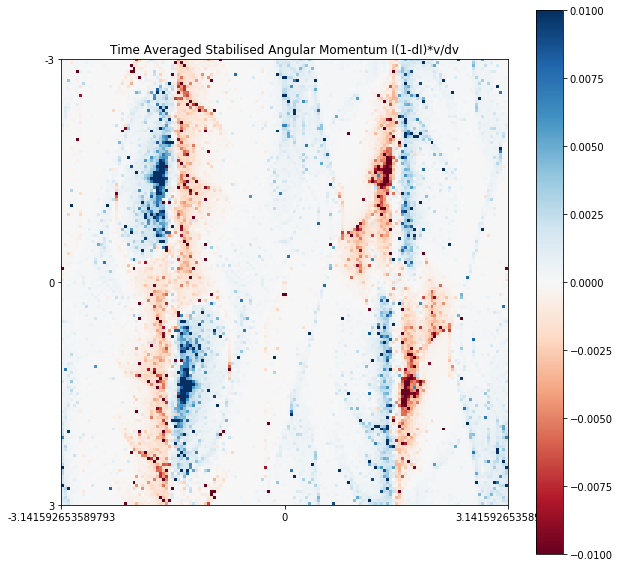

In [506]:
showResults(I_19,dI_19,om_19,dom_19,I_s_19,I_sa_19,om_s_19,om_sa_19,p_19,p_s_19,p_sa_19,p_ssa_19,mu_19)

In [ ]:
div = 150
phi_range = np.sort(np.append(np.linspace(-np.pi,np.pi,div-1),0))
m_range = np.linspace(-3*np.sqrt(3),3*np.sqrt(3),div)
I_19_2,dI_19_2,om_19_2,dom_19_2,I_s_19_2,I_sa_19_2,om_s_19_2,om_sa_19_2,p_19_2,p_s_19_2,p_sa_19_2,p_ssa_19_2,mu_19_2 = scanEdgeBehavior(phi_range,m_range,True,3,1,15)

In [518]:
#no Wavepacket broadening
div = 150
phi_range = np.sort(np.append(np.linspace(-np.pi,np.pi,div-1),0))
m_range = np.linspace(-3*np.sqrt(3),3*np.sqrt(3),div)
I_10,dI_10,om_10,dom_10,I_s_10,I_sa_10,om_s_10,om_sa_10,p_10,p_s_10,p_sa_10 = scanEdgeBehavior(phi_range,m_range,True,2,1,9)

0.99995555555555564567

ValueError: too many values to unpack (expected 11)

<Figure size 432x288 with 0 Axes>

In [59]:
f = open("10Particle.txt", "a")
f.write("I\n")
for I in I_10:
    for II in I:
        f.write(str(II)+'\n')
f.write("dI\n")
for I in dI_10:
    for II in I:
        f.write(str(II)+'\n')
f.write("om\n")
for I in om_10:
    for II in I:
        f.write(str(II)+'\n')
f.write("dom\n")
for I in dom_10:
    for II in I:
        f.write(str(II)+'\n')
f.close()

In [ ]:
showResults(I_10,dI_10,om_10,dom_10,I_s_10,I_sa_10,om_s_10,om_sa_10,p_10,p_s_10,p_sa_10)

In [442]:
## With wavepacket broadening
div = 150
phi_range = np.sort(np.append(np.linspace(-np.pi,np.pi,div-1),0))
m_range = np.linspace(-3*np.sqrt(3),3*np.sqrt(3),div)
I_10s,dI_10s,om_10s,dom_10s,I_s_10s,I_sa_10s,om_s_10s,om_sa_10s,p_10s,p_s_10s,p_sa_10s,p_ssa_10s,mu_10s = scanEdgeBehavior(phi_range,m_range,True,2,1,9)

0.99995555555555564567

<Figure size 432x288 with 0 Axes>

In [ ]:
showResults(I_10s,dI_10s,om_10s,dom_10s,I_s_10s,I_sa_10s,om_s_10s,om_sa_10s,p_10s,p_s_10s,p_sa_10s,p_ssa_10s,mu_10s)

In [ ]:
div = 150
phi_range = np.sort(np.append(np.linspace(-np.pi,np.pi,div-1),0))
m_range = np.linspace(-3*np.sqrt(3),3*np.sqrt(3),div)
I_30,dI_30,om_30,dom_30 = scanEdgeBehavior(phi_range,m_range,True,4,1,30)

I_f = np.transpose(I_30)/np.amax(I_30)
dI_f = np.transpose(dI_30)/np.amax(dI_30)
om_f = np.transpose(om_30)/np.amax(np.absolute(om_30))
dom_f= np.transpose(dom_30)/np.amax(np.absolute(dom_30))

In [631]:
div = 150
phi_range = np.sort(np.append(np.linspace(-np.pi/5,np.pi/5,div-1),0))
m_range = np.linspace(-1,1,div)

I_s,dI_s,om_s,dom_s = scanEdgeBehavior(phi_range,m_range,True,2,1,9)


0.99995555555555564567

<Figure size 432x288 with 0 Axes>

In [517]:
div = 150
phi_range = np.sort(np.append(np.linspace(-np.pi,np.pi,div-1),0))
m_range = np.linspace(-3*np.sqrt(3), 3*np.sqrt(3),div)
I_16,dI_16,om_16,dom_16,I_s_16,I_sa_16,om_s_16,om_sa_16,p_16,p_s_16,p_sa_16,p_ssa_16,mu_16 = scanEdgeBehavior(phi_range,m_range,False,3,1,15)

0.99995555555555564567

<Figure size 432x288 with 0 Axes>

In [516]:
showResults(I_16,dI_16,om_16,dom_16,I_s_16,I_sa_16,om_s_16,om_sa_16,p_16,p_s_16,p_sa_16,p_ssa_16,mu_16)

NameError: name 'I_s_16' is not defined

1.745 -1


<Figure size 432x288 with 0 Axes>

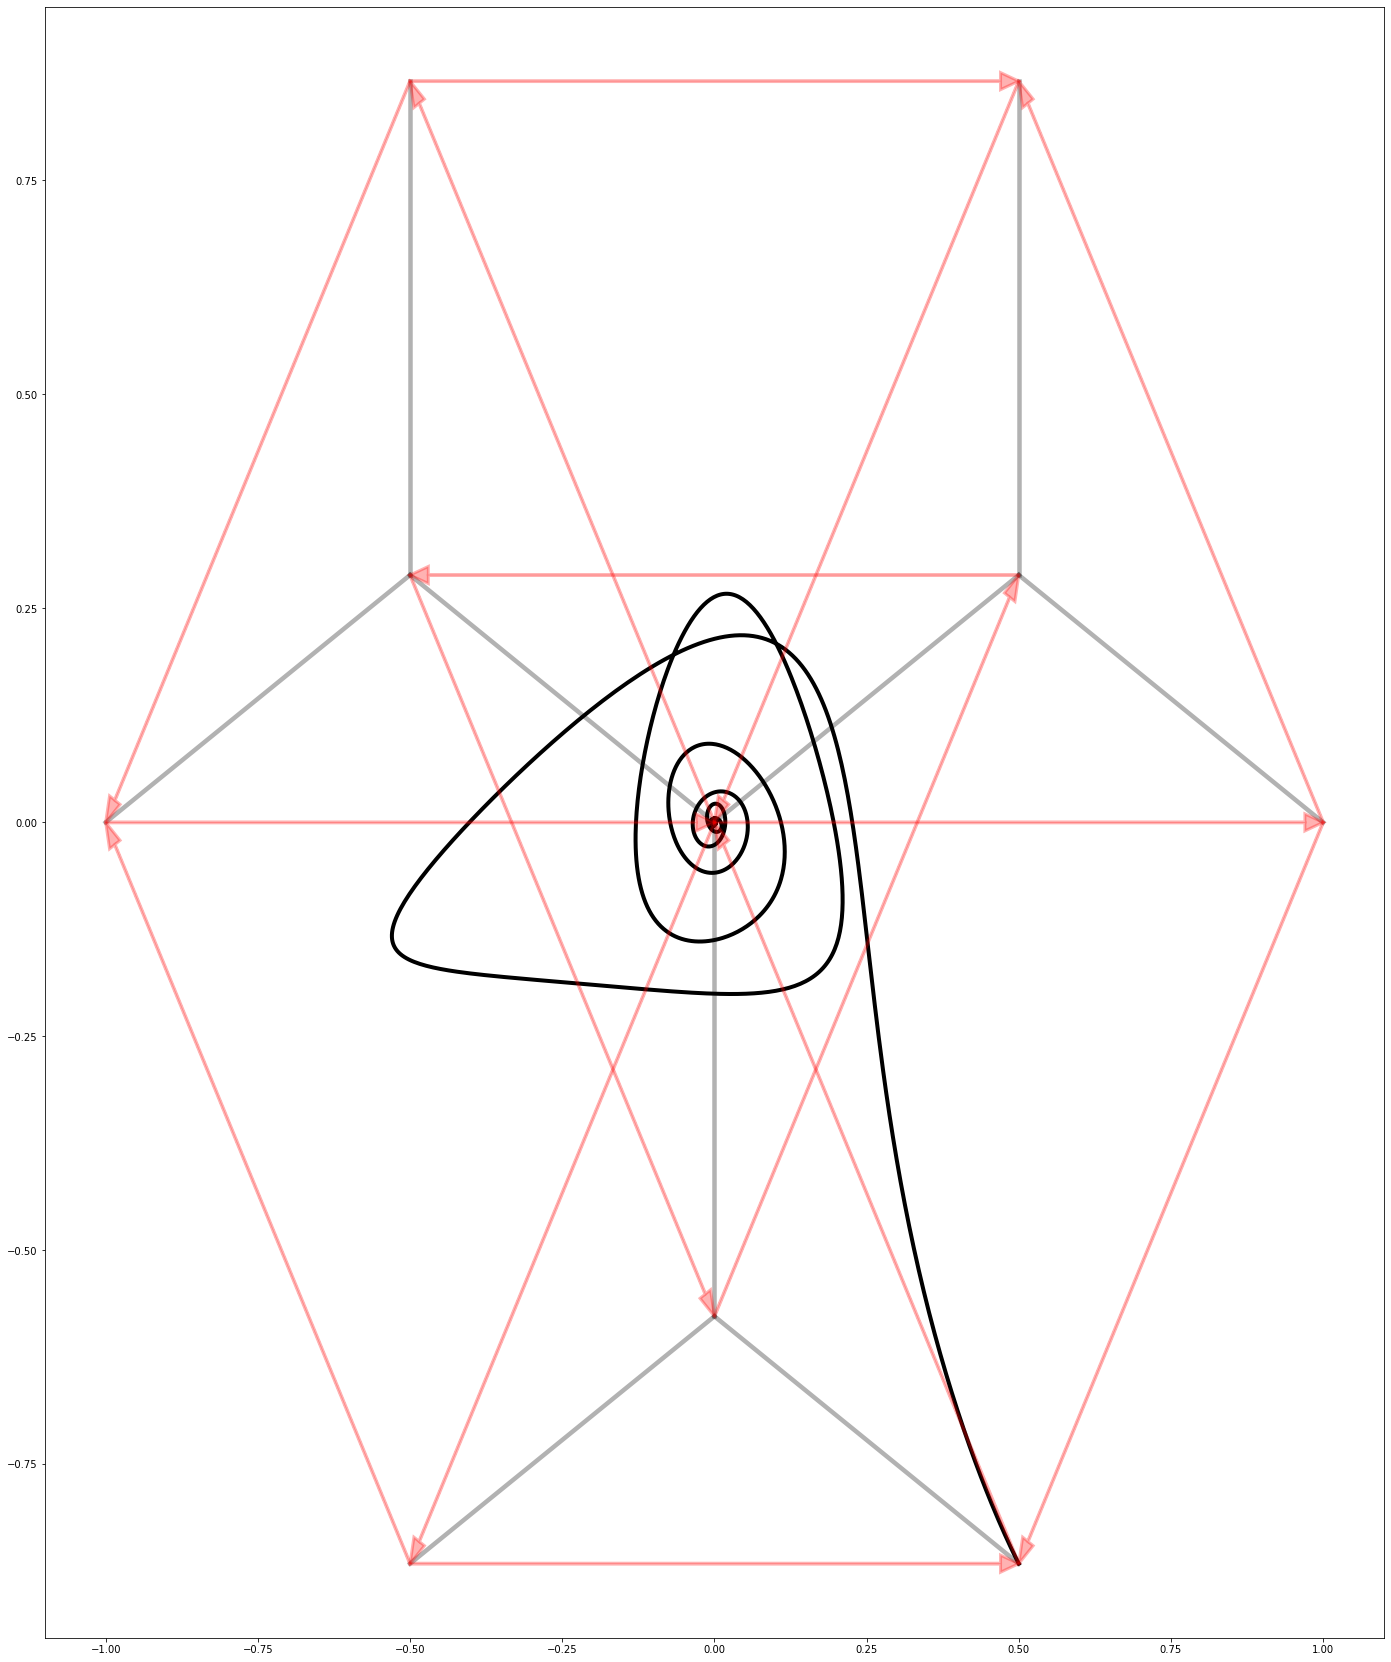

134
3.1016291126984745 3.1003416852576087
-0.039963540891318594 -0.041250968332184446
429
3.131124750898837 3.131081217305803
-0.010467902690955988 -0.010511436283989983
720
3.119973689188361 3.1202033008401924
-0.021618964401432184 -0.021389352749600743
1027
3.115543369089495 3.1154050228820815
-0.026049284500297976 -0.026187630707711573
1323
3.126739437343205 3.126756377226409
-0.014853216246588197 -0.014836276363384027
1624
3.1031699578007665 3.1030593393493557
-0.03842269578902657 -0.03853331424043738
1925
3.131008804767135 3.131019351516518
-0.010583848822657949 -0.010573302073275226
2222
3.040453732952681 3.041249320338723
-0.10113892063711205 -0.10034333325106992
2534
3.1354911135587047 3.1354976406473942
-0.006101540031088426 -0.006095012942398892
3034
-3.0962548367251994 -3.1032725423974665
0.045337816864593705 0.03832011119232659
3652
-2.2184446364305557 -2.54722057201161
0.9231480171592374 0.5943720815781832
3020 0.11680659218000633 4.721625342728687
3021 0.1361748747560667 

ValueError: too many values to unpack (expected 8)

In [309]:
# perturbTrajectory(phi,m,takes,err,symm,sets,obs_basis,state_ind)
scanEdgeBehavior([1.745],[-1],True,2,1,9)


In [ ]:
scanEdgeBehavior([-1.745],[1],True,2,1,9)

/Users/jordankemp/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


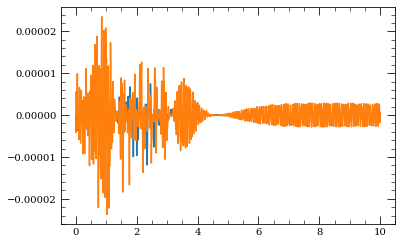

In [209]:
state =eVecs[3]+eVecs[6]
periods =50           #How many time periods
step = 250
hf =[]
lf = []
sets = 2     #How many coupling pairs
ww = np.linspace(0,10,1000)
for w in ww:
    step = 2500+(w*10000)
    nodes,site_num,H,proj,eVals,eVecs=prepHamiltonian(symm,sets,obs_basis,w,w,w)
    high_freq,low_freq = runHamiltonian(site_num,1,H,proj,obs_basis,state,periods,step)
    hf.append(high_freq[0])
    lf.append(low_freq[0])
plt.plot(ww,hf)
plt.plot(ww,lf)

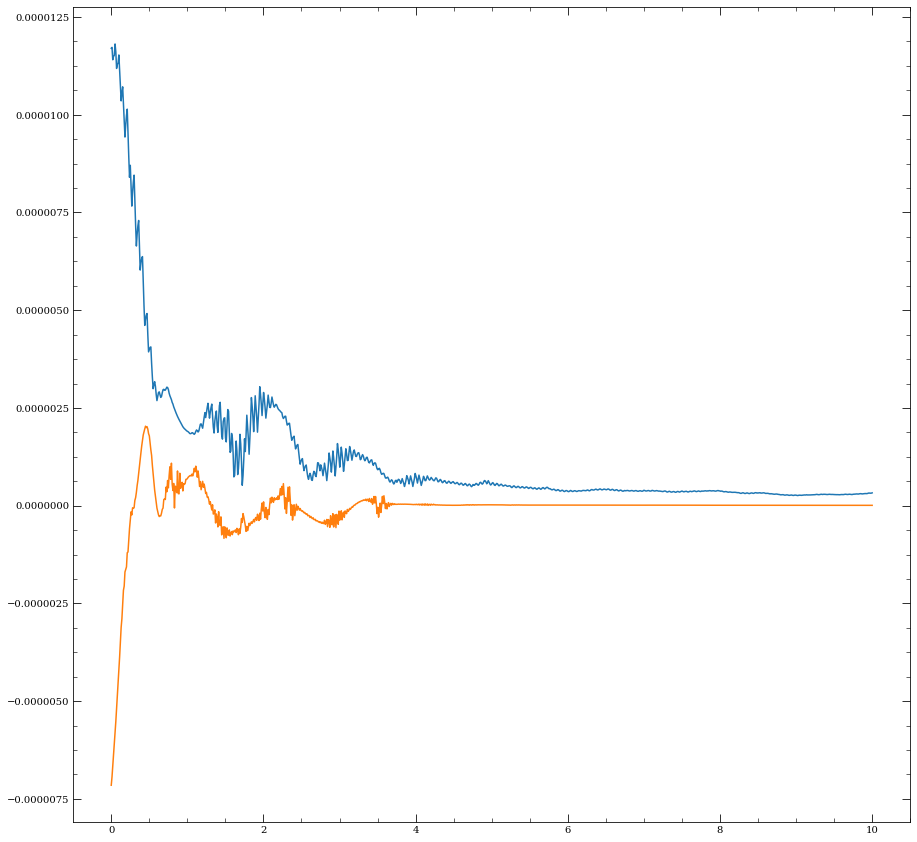

In [206]:
plt.figure(figsize=(15,15))
from scipy import interpolate

# plt.ylim(bottom=-.000075)
# plt.ylim(top=1)
# plt.plot(ww,hf)
plt.plot(ww,savitzky_golay(hf,151,5))
plt.plot(ww,savitzky_golay(hf_deeper,151,5))


# plt.plot(ww,hf,alpha=.5)
plt.show()

In [146]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    window_size = np.abs(np.int(window_size))
    order = np.abs(np.int(order))

    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')


In [395]:
from numpy.random import multivariate_normal

data = np.vstack([
    multivariate_normal([10, 10], [[3, 2], [2, 3]], size=100000),
    multivariate_normal([30, 20], [[2, 3], [1, 3]], size=1000)
])

/Users/jordankemp/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: covariance is not positive-semidefinite.
  """


In [396]:
data

array([[ 9.77933316,  8.99476552],
       [10.06406309, 12.12763542],
       [ 9.88061556, 12.23151888],
       ...,
       [31.67887863, 22.17552027],
       [30.64171767, 20.91414811],
       [28.39581452, 20.64937179]])

In [397]:

data[:, 0]

array([ 9.77933316, 10.06406309,  9.88061556, ..., 31.67887863, 30.64171767, 28.39581452])

In [420]:
coord = [1,1,1]
x=round(coord[1]*np.sin(theta)+coord[0]+ coord[2]*(1/3)*(1+np.sin(theta)),3)
y=round(coord[1]*np.cos(theta)         + coord[2]*(1/3)*(np.cos(theta)),3)
v= np.rot90([[x,0],[0,y]],1)




In [422]:
v[0][1]

1.155

In [423]:
v[1][0]

2.0

In [56]:
M=.25
P=.5
symm=False
sets=3
obs_basis=1
nodes,site_num,H,proj,eVals,eVecs=prepHamiltonian(symm,sets,obs_basis,1,1,1)


0.289 0.011691663670633073 0.5 -0.004455973651961402
0.289 -0.006137441626541586 1.5 0.0116408426351026
0.0 0.009636606379866866 1.0 0.011051563545959564
0.289 -0.013372021863527195 2.5 -0.0024299218730885527
0.0 -0.014568601719163427 2.0 0.0036674286236669483
1.155 -0.007550735512076042 1.0 -0.008990006029899264
0.866 -0.012246001565573688 0.5 -0.01131019860816188
1.155 0.001600384958776623 2.0 -0.00818977773589849
0.866 -0.004875542216626511 1.5 0.006679591907791754
1.155 -0.0005763436460736751 3.0 0.011567036851778834
0.866 -0.0013813205340655903 2.5 -0.008343405269946294
2.021 0.008040919245889025 1.5 0.001852468366602423
1.732 0.0006366647403467621 1.0 -0.01797100008948354
2.021 -0.0050115220535898 2.5 0.013554033049715664
1.732 0.017822928512116375 2.0 -0.0038748104769716534
1.732 -0.004028510873195288 3.0 -0.0016401439163452694


In [84]:
from itertools import product

names = ['Brown', 'Wilson', 'Bartlett', 'Rivera', 'Molloy', 'Opie']
product(names, repeat=2)

In [691]:
x=[None]
def var(x):
    x[0]=10
var(x)
print(x)

[10]


In [116]:
del(P)

In [131]:
np.gradient([1,2,3,4,2,10])

array([ 1. ,  1. ,  1. , -0.5,  3. ,  8. ])

In [363]:
def angle(p):
    ang1 = 0
    ang2 = np.arctan2(*p[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))
360-angle([0,1])

90.0

In [371]:
np.arctan2([1,1],[1,2])*180/np.pi

array([45.        , 26.56505118])

In [380]:
def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

In [675]:
qutip.settings.num_cpus=4

In [674]:
qutip.settings.num_cpus

6

In [11]:
adj = [[0,1,1],[1,0,1],[1,0,1]]
genHamiltonianFromAdjMatrix(adj,-1)

IndexError: list index out of range

In [12]:
print(adj)

[[0, 1, 1], [1, 0, 1], [1, 0, 1]]


In [84]:
l = str([1,2,4])

In [189]:
def calcAngularVelocity(p_x,p_y,periods):
    p2=2*np.pi
    th = np.arctan2(p_x,p_y)
    corrections_list=[]
    
    if th[0]<0:
        th[0]=p2+th[0]
        corrections_list.append(0)
    
    for i in range(1,len(th)):
        if th[i]<0:
            th[i]=p2+th[i]
            corrections_list.append(i)
        elif np.absolute(th[i]-th[i-1])>np.pi:
            corrections_list.append(i)
    print(corrections_list)
    om = np.gradient(th,1)
    for c in corrections_list:
        om[c]=np.pi+om[c]
#     return(np.gradient(om))
    om = np.delete(om,-1)
    dom = np.delete(np.gradient(om),-1)
    return np.average(om/periods),np.average(np.absolute(dom)/periods)

In [190]:
calcAngularVelocity([1,0,-1,0,1,0,-1,0,1,0,-1,0],[0,-1,0,1,0,-1,0,1,0,-1,0,1],1)

[2, 3, 6, 7, 10, 11]


(1.5707963267948963, 0.0)

In [114]:
calcAngularVelocity([1,np.sqrt(2)/2,0],[0,np.sqrt(2)/2,1],1)

(array([1.57079633, 0.78539816, 0.        ]),
 array([-0.78539816, -0.78539816, -0.78539816]))

In [115]:
calcAngularVelocity([1,np.sqrt(2)/2,0],[0,-np.sqrt(2)/2,-1],1)

(array([1.57079633, 2.35619449, 3.14159265]),
 array([0.78539816, 0.78539816, 0.78539816]))

In [153]:
for i in range(1,10):
    print(i)

1
2
3
4
5
6
7
8
9
